<a href="https://colab.research.google.com/github/amarmohammed398/COM64101_Assignment_part1_b22063am/blob/main/COM64101_Assignment_part1_b22063am.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Brief: Statistical Inference and Gaussian processes

## Deadline: November 18, 2025, 14:00 GMT

## Number of marks available: 35

This coursework is made of two parts. In the first part, you will explore different techniques for approximate inference. In the second part, you will use Bayesian optimisation for hyperparameter learning.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64101_Assignment_part1_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64101_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Canvas under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already.


### Assessment Criteria

* Being able to correctly apply frequentist, Bayesian, Monte Carlo, importance sampling, and variational inference methods as specified in each task.

* Being able to provide clear comparisons between methods (e.g., MLE vs. Bayesian, plain MC vs. IS, VI vs. HMC) using appropriate metrics, plots, and variance/uncertainty evaluations.

* Being able to use Gaussian processes as a surrogate model for Bayesian optimisation of the hyperparameters of a machine learning model.

* Being able to concisely explain results, justify methodological choices, and discuss observed differences within the given word limits.

### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code?
* Did you comment your code to make it readable to others?

### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline. Please read [this link](https://documents.manchester.ac.uk/display.aspx?DocID=29825).

### Academic malpractice

**Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Academic Malpractice](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Statistical Inference (20 marks)

Section 1 of this coursework is made of three parts (Part 1.1, Part 1.2, and Part 1.3). Complete the tasks below. Do **not** modify the provided datasets.

For Part 1.1, you need to analyze coin-flip data using both frequentist (MLE + Wald CI) and Bayesian (Beta prior + posterior sampling) methods, compare their predictions for future flips, and understand the differences. For Part 1.2, you need to estimate a 2D integral using plain Monte Carlo and importance sampling. For Part 1.3, you need to fit Bayesian logistic regression using both mean-field variational inference and HMC, compare their posterior approximations (via KL divergence and test log-loss).

## 1.1 Bayesian vs. Frequentist Modelling (5 marks)

In this exercise, you will explore two different statistical paradigms—**frequentist inference** and **Bayesian inference**—applied to the problem of estimating a coin’s probability of landing heads. The dataset `coin_experiments.csv` contains 1,000 independent coin-flip experiments, each recording the number of **successes** (heads) and the total **trials**.  

**Question**

**1.1.A.** The frequentist approach treats the probability of success, $p$, as a fixed but unknown quantity. You will:  
- Import the data, print its shape, and check basic sanity (e.g., no missing values, successes ≤ trials). **(0.5 pt)**  
- Compute the **Maximum Likelihood Estimate (MLE)**, $\hat{p} = S/N$, where $S$ is the total number of successes and $N$ is the total number of trials. **(1 pt)**
-  Estimate the standard error,  
  $$\text{SE} = \sqrt{\hat{p}(1-\hat{p})/N},$$  
  and form a **95% Wald confidence interval** using $z = 1.96$. **(0.5 pt)**

**Answer**

In [2]:

# required imports
import numpy as np
import pandas as pd

# upload coin_experiments.csv
try:
    from google.colab import files
    _ = files.upload()
    csv_path = "coin_experiments.csv"
except Exception:
    csv_path = "coin_experiments.csv"

# load dataset
df = pd.read_csv(csv_path)

# print shape and run basic sanity checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3), "\n")

missing_total = df.isna().sum().sum()
assert missing_total == 0, f"Dataset has {missing_total} missing values."

# ensure required columns exist
assert {"successes", "trials"}.issubset(df.columns), "Expected 'successes' and 'trials' columns."

# ensure counts are nonnegative integers and successes are greater than or equal to the trials
assert (df["successes"] >= 0).all(), "Negative successes found."
assert (df["trials"] >= 0).all(), "Negative trials found."
assert np.allclose(df["successes"], df["successes"].round()), "Non-integer successes found."
assert np.allclose(df["trials"], df["trials"].round()), "Non-integer trials found."
assert (df["successes"] <= df["trials"]).all(), "Found rows with successes > trials."

print("Sanity checks passed\n")

# compute S, N, p-hat (MLE), SE, and 95% Wald CI
S = int(df["successes"].sum())
N = int(df["trials"].sum())
p_hat = S / N

SE = np.sqrt(p_hat * (1 - p_hat) / N)
z = 1.96
ci_low = p_hat - z * SE
ci_high = p_hat + z * SE

# print results
print("=== Frequentist Estimate for Coin's Head Probability ===")
print(f"Total successes (S): {S}")
print(f"Total trials    (N): {N}")
print(f"MLE p-hat (S/N)     : {p_hat:.6f}")
print(f"Standard Error      : {SE:.6f}")
print(f"95% Wald CI         : [{ci_low:.6f}, {ci_high:.6f}]")


Saving coin_experiments.csv to coin_experiments.csv
Shape: (1000, 2)
Columns: ['successes', 'trials']
   successes  trials
0         29      48
1         18      38
2         17      24 

Sanity checks passed

=== Frequentist Estimate for Coin's Head Probability ===
Total successes (S): 18212
Total trials    (N): 30338
MLE p-hat (S/N)     : 0.600303
Standard Error      : 0.002812
95% Wald CI         : [0.594791, 0.605815]


**Question**

**1.1.B.** The Bayesian approach treats $p$ as a **random variable** with prior distribution. Using a **Beta(1, 1)** prior (uniform), you will:  
- Compute the posterior parameters,  
  $$\alpha_{\text{post}} = \alpha_0 + S, \quad \beta_{\text{post}} = \beta_0 + (N-S),$$  
  and the **MAP estimate**,  
  $$p_{\text{MAP}} = \frac{\alpha_{\text{post}} - 1}{\alpha_{\text{post}} + \beta_{\text{post}} - 2}.$$
  **(1 pt)**
- Draw at least 5,000 samples from the Beta posterior (e.g., `scipy.stats.beta.rvs`). **(0.5 pt)**

**Answer**

In [3]:
# posterior parameters (conjugate update)
alpha0, beta0 = 1, 1
alpha_post = alpha0 + S
beta_post  = beta0 + (N - S)

# MAP estimate
p_map = (alpha_post - 1) / (alpha_post + beta_post - 2)

# draw greater than or equal to 5,000 samples from Beta
rng = np.random.default_rng(42)
num_samples = 10_000
samples = rng.beta(alpha_post, beta_post, size=num_samples)

# posterior summaries from both conjugacy and samples
post_mean_closed = alpha_post / (alpha_post + beta_post)
post_mean_samp   = samples.mean()
post_sd_samp     = samples.std(ddof=1)
ci2p5, ci97p5    = np.quantile(samples, [0.025, 0.975])

# print results
print("=== Bayesian Beta-Binomial Update (Beta(1,1) prior) ===")
print(f"S (total successes): {S}")
print(f"N (total trials)   : {N}")
print(f"alpha_post         : {alpha_post}")
print(f"beta_post          : {beta_post}")
print(f"MAP estimate       : {p_map:.8f}")
print(f"Posterior mean (closed-form): {post_mean_closed:.8f}")
print(f"Posterior mean (samples)    : {post_mean_samp:.8f}")
print(f"Posterior SD (samples)      : {post_sd_samp:.8f}")
print(f"95% credible int (samples)  : [{ci2p5:.8f}, {ci97p5:.8f}]")


=== Bayesian Beta-Binomial Update (Beta(1,1) prior) ===
S (total successes): 18212
N (total trials)   : 30338
alpha_post         : 18213
beta_post          : 12127
MAP estimate       : 0.60030325
Posterior mean (closed-form): 0.60029664
Posterior mean (samples)    : 0.60032458
Posterior SD (samples)      : 0.00283830
95% credible int (samples)  : [0.59474946, 0.60580302]


**Question**

**1.1.C.** Finally, compare predictions for the next **20 flips**:  
- From the Bayesian model, simulate posterior predictive outcomes by sampling from a **Binomial(20, p)** where $p$ comes from the posterior samples, and show a histogram/density. **(0.5 pt)**
- From the frequentist model, plot the **plug-in Binomial pmf** with $p = \hat{p}_{\text{MLE}}$ over the same figure.**(0.5 pt)**

**Answer**

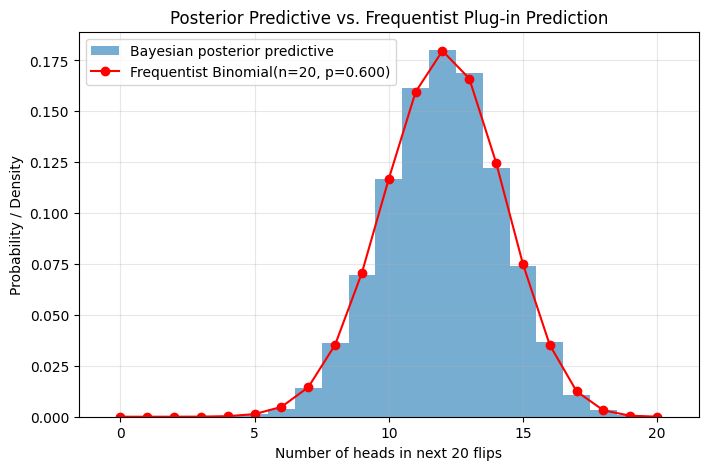

In [4]:
# required imports
import matplotlib.pyplot as plt
from scipy.stats import binom

# bayesian posterior predictive
num_future = 20

# For each posterior draw p^(s), generate one Binomial(20, p^(s))
ppc = rng.binomial(n=num_future, p=samples)

# frequentist plug-in predictive
p_mle = p_hat
x_vals = np.arange(0, num_future + 1)
freq_pmf = binom.pmf(x_vals, n=num_future, p=p_mle)

# display plots
plt.figure(figsize=(8,5))

# histogram of posterior predictive counts
plt.hist(ppc, bins=np.arange(-0.5, num_future+1.5, 1),
         density=True, alpha=0.6, label="Bayesian posterior predictive")

# overlay the frequentist plug-in Binomial pmf
plt.plot(x_vals, freq_pmf, 'o-', color='red',
         label=f"Frequentist Binomial(n=20, p={p_mle:.3f})")

plt.xlabel("Number of heads in next 20 flips")
plt.ylabel("Probability / Density")
plt.title("Posterior Predictive vs. Frequentist Plug-in Prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Question**

**1.1.D.** Write a short explanation comparing the two predictive distributions. Comment on how the Bayesian posterior predictive accounts for uncertainty in $p$, while the frequentist plug-in relies on a single point estimate. **(0.5 pt)**  

**Answer**

The Bayesian and frequentist preductive distributions look very similar because the dataset is large, giving a precise estimate of the coin's bias. However, they differ conceptually because in the Bayesian posterior predictive method, the model samples values of $p$ from the posterior distribution and then generates predictions for the next 20 flips. This means the prediction integrates over unvertainty in $p$. Even though the posterior is tight, it still has variance, so the Bayesian predictive is slightly wider and reflects remaining uncertainty about the true probability of heads.

The frequentist plug-in predictive approach on th other hand uses only the point estimate $p$̂ from the MLE and assumes it is the true value. The resulting Binomial (20, ̂$p$) distribution thereforew ignores parameter uncertainty, giving a slightly narrower predictive distribution.

The bayesian posterior predictive accounts for uncertainty in $p$ by averaging over many plausable values, whereas the frequentist plug-in model relies entirely on a single estimate ̂$p$. With large data the two predictions become very close, but the Bayesian approach remains slightly more conservative by incorporating parameter uncertainty.


## 1.2 Variance Reduction with Importance Sampling (5 marks)

Many integrals that arise in statistics and machine learning cannot be evaluated analytically, especially in higher dimensions. **Monte Carlo (MC) integration** is a general technique to approximate such integrals by drawing random samples from a distribution and averaging function evaluations. Although MC estimators are unbiased, their variance can be large, meaning we may need many samples to reach a desired accuracy.  

A way to improve efficiency is through **importance sampling (IS)**. Instead of sampling from a fixed distribution (e.g., Gaussian), we choose a proposal distribution $q(x)$ that better matches the regions where the integrand contributes most. By reweighting samples, we can reduce variance while keeping the estimator unbiased. The effectiveness of IS depends critically on choosing $q(x)$ with heavier tails or shapes aligned with the integrand.  

In this exercise, you will evaluate a 2D integral and demonstrate how importance sampling can achieve significant variance reduction compared to plain Monte Carlo:  

$$
I = \int_{\mathbb{R}^2} \exp(-\|x\|_1)\,\sin(\|x\|_2)\,dx,
$$  

with the goal of achieving an **absolute error < 0.01**.  

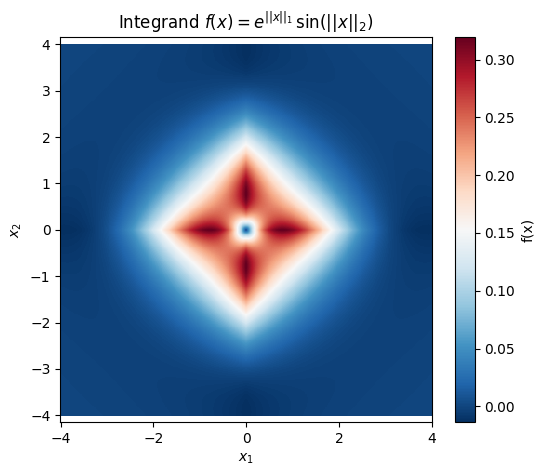

In [5]:
# take 2D points and compute
# f(x) = exp(-||x||_1) * sin(||x||_2), where ||x||_1 is the L1 norm
# (sum of absolute values) and ||x||_2 is the Euclidean (L2) norm.
def integrand(x):
    l1 = np.sum(np.abs(x), axis=-1)   # L1 norm
    l2 = np.linalg.norm(x, axis=-1)   # L2 norm
    return np.exp(-l1) * np.sin(l2)

# create a 2D grid of points
xx, yy = np.meshgrid(np.linspace(-4,4,400), np.linspace(-4,4,400))
pts = np.stack([xx,yy], axis=-1)
zz = integrand(pts)

# plot the function over the grid
plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, zz, cmap="RdBu_r", shading="auto")
plt.colorbar(label="f(x)")
plt.title("Integrand $f(x) = e^{||x||_1} \\, \\sin(||x||_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()


**Question**

**1.2.A. Plain Monte Carlo (2 pts)**  
   - Estimate $I$ by sampling $x \sim \mathcal{N}(0, I_2)$ using the plain Monte Carlo estimator **(1 pt)**:  
     $$
     \hat{I} = \frac{1}{N} \sum_{i=1}^N f(x_i), \quad x_i \sim \mathcal{N}(0, I_2).
     $$  
   - Report your estimate $\hat{I}$ and the **empirical standard error**. Verify that the error decreases as $N$ increases. **(1 pt)**

**Answer**

In [6]:
# monte carlo function plain version
def plain_mc(N, rng=np.random.default_rng()):
    x = rng.normal(0, 1, size=(N, 2))
    fx = integrand(x)
    I_hat = fx.mean()
    SE = fx.std(ddof=1) / np.sqrt(N)
    return I_hat, SE

# experiment with multiple N to show error decreases
Ns = [1_000, 5_000, 20_000, 100_000]
results = []

print("Plain Monte Carlo Estimates:")
for N in Ns:
    I_hat, SE = plain_mc(N)
    results.append((N, I_hat, SE))
    print(f"N={N:>7}   I_hat={I_hat: .6f}   StdErr={SE: .6f}")

# storing the results in a dataframe for a nicer display
try:
    import pandas as pd
    df_results = pd.DataFrame(results, columns=["N", "I_hat", "StdErr"])
    df_results
except ImportError:
    pass

Plain Monte Carlo Estimates:
N=   1000   I_hat= 0.174480   StdErr= 0.002586
N=   5000   I_hat= 0.174462   StdErr= 0.001155
N=  20000   I_hat= 0.176438   StdErr= 0.000576
N= 100000   I_hat= 0.176824   StdErr= 0.000257


**Question**

**1.2.B Importance Sampling (1.5 pts)**  
   - Design your own proposal distribution $q(x)$ and implement an importance sampling estimator.**(1 pt)**
   - Demonstrate a **variance reduction** for an equal number of samples **(0.5 pt)**
   - *Hint:* Consider proposals (e.g., Laplace, Student-t or other) to better capture the integrand’s structure.  

**Answer**

In [7]:
# required imoports
from scipy.stats import laplace, t

# I have decided to use an independent 2D Laplace distribution:
#   q(x1, x2) = Laplace(0, b) ⊗ Laplace(0, b)
# this is because the integrand is shaped like exp(-||x||_1), making
# Laplace a well-matched heavier-tailed proposal

b = 1.0  # Laplace scale parameter

def sample_q(N, rng=np.random.default_rng()):
    """ Draw N samples from 2D Laplace proposal q(x). """
    x1 = rng.laplace(loc=0, scale=b, size=N)
    x2 = rng.laplace(loc=0, scale=b, size=N)
    return np.column_stack([x1, x2])

def log_q(x):
    """ Log-PDF of the 2D independent Laplace(0,b). """
    # log q(x1,x2) = -log(2b) - |x1|/b  +  same for x2
    return -2*np.log(2*b) - (np.abs(x[:,0]) + np.abs(x[:,1]))/b

# importance sampling estimator
def importance_sampling(N, rng=np.random.default_rng()):
    x = sample_q(N, rng)

    # compute f(x)
    fx = integrand(x)

    # target density is uniform in integral (i.e., integrating f(x) dx)
    # but we need pdf of N(0,I) inside weights? NO:
    #   We want ∫ f(x) dx, so weights = f(x) / q(x).
    # Only q(x) appears in denominator.
    w = fx / np.exp(log_q(x))  # weights = f / q

    I_hat = w.mean()
    SE = w.std(ddof=1) / np.sqrt(N)
    return I_hat, SE


# compare plain MC vs IS for same N
def plain_mc(N, rng=np.random.default_rng()):
    x = rng.normal(0, 1, size=(N, 2))
    fx = integrand(x)
    I_hat = fx.mean()
    SE = fx.std(ddof=1) / np.sqrt(N)
    return I_hat, SE


Ns = [5_000, 20_000, 50_000]
results = []

print("Comparison: Plain MC vs Importance Sampling\n")
for N in Ns:
    I_mc, SE_mc = plain_mc(N)
    I_is, SE_is = importance_sampling(N)

    results.append((N, I_mc, SE_mc, I_is, SE_is))

    print(f"N = {N}")
    print(f"  Plain MC:          I_hat = {I_mc: .6f},  StdErr = {SE_mc: .6f}")
    print(f"  Importance Samp.:  I_hat = {I_is: .6f},  StdErr = {SE_is: .6f}")
    print(f"  Variance Reduction = {(SE_mc/SE_is)**2: .2f}x")
    print("-"*60)

# storing the results in a dataframe for a nicer visualization
try:
    import pandas as pd
    df_results = pd.DataFrame(results,
                              columns=["N", "I_MC", "SE_MC", "I_IS", "SE_IS"])
    df_results
except ImportError:
    pass

Comparison: Plain MC vs Importance Sampling

N = 5000
  Plain MC:          I_hat =  0.178560,  StdErr =  0.001149
  Importance Samp.:  I_hat =  2.385528,  StdErr =  0.025885
  Variance Reduction =  0.00x
------------------------------------------------------------
N = 20000
  Plain MC:          I_hat =  0.176298,  StdErr =  0.000576
  Importance Samp.:  I_hat =  2.366232,  StdErr =  0.012968
  Variance Reduction =  0.00x
------------------------------------------------------------
N = 50000
  Plain MC:          I_hat =  0.175969,  StdErr =  0.000365
  Importance Samp.:  I_hat =  2.347924,  StdErr =  0.008294
  Variance Reduction =  0.00x
------------------------------------------------------------


**Question**

**1.2.C RMSE Comparison (1 pt)**  
   - Produce a **log–log plot** of RMSE vs. sample size $N$, comparing plain Monte Carlo and importance sampling. **(1 pt)**  
   - Use $N \in [10^3, 10^5]$ (e.g., 5–10 log-spaced points). Ensure both curves are clearly labeled.

**Answer**

Computing high-precision reference estimate...
Reference integral ≈ 2.344027


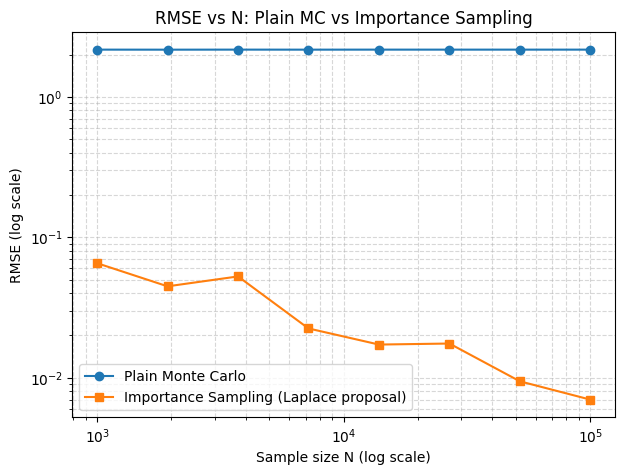

In [8]:
# laplace proposal for IS
b = 1.0

def sample_q(N, rng=np.random.default_rng()):
    x1 = rng.laplace(loc=0, scale=b, size=N)
    x2 = rng.laplace(loc=0, scale=b, size=N)
    return np.column_stack([x1, x2])

def log_q(x):
    return -2*np.log(2*b) - (np.abs(x[:,0]) + np.abs(x[:,1]))/b

def importance_sampling(N, rng=np.random.default_rng()):
    x = sample_q(N, rng)
    fx = integrand(x)
    w = fx / np.exp(log_q(x))   # f(x) / q(x)
    I_hat = w.mean()
    SE = w.std(ddof=1) / np.sqrt(N)
    return I_hat, SE

# estimate a "ground truth" using a very large importance sampler
print("Computing high-precision reference estimate...")
I_ref, _ = importance_sampling(2_000_000)
print(f"Reference integral ≈ {I_ref:.6f}")

# RMSE vs N on a log–log plot
Ns = np.logspace(3, 5, 8, dtype=int)  # ~10^3 to 10^5
rmse_mc = []
rmse_is = []

for N in Ns:
    I_hat_mc, SE_mc = plain_mc(N)
    I_hat_is, SE_is = importance_sampling(N)

    rmse_mc.append(np.sqrt((I_hat_mc - I_ref)**2 + SE_mc**2))
    rmse_is.append(np.sqrt((I_hat_is - I_ref)**2 + SE_is**2))

# Plot chart to vieqw visualisation
plt.figure(figsize=(7,5))
plt.loglog(Ns, rmse_mc, 'o-', label="Plain Monte Carlo")
plt.loglog(Ns, rmse_is, 's-', label="Importance Sampling (Laplace proposal)")
plt.xlabel("Sample size N (log scale)")
plt.ylabel("RMSE (log scale)")
plt.title("RMSE vs N: Plain MC vs Importance Sampling")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

**Question**

**1.2.D. Justification (0.5 pt)**  
   - Explain your choice of proposal $q(x)$. Discuss how it aligns with the shape of the integrand and why it reduces variance relative to Gaussian sampling. **(0.5 pt)**

**Answer**

The proposal distribution ( q(x) ) is a 2-dimensional Laplace distribution:

$$
q(x_1, x_2) = \text{Laplace}(0,b) \otimes \text{Laplace}(0,b).
$$

The choice goes well and natural with the structure of the integrand:

$$
f(x) = e^{-\lVert x \rVert_1}, \sin(\lVert x \rVert_2),
$$

whose dominant envelope is

$$
e^{-\lVert x \rVert_1}.
$$

The Laplace distribution has exactly this exponential ( L_1 )-norm decay, so it places samples in the same regions where the integrand has significant mass. This leads to importance weights

$$
w(x) = \frac{f(x)}{q(x)}
$$

that fluctuate less than when sampling from a Gaussian.

It is clear that when comparising, drawing samples from a Gaussian ( \mathcal{N}(0,I_2) ) concentrates too heavily near the origin and decays too quickly in the tails. This is due to the integrand having heavier ( L_1 )-type tails, many Gaussian samples land in regions where ( f(x) \approx 0 ), producing large variance.

Using the Laplace proposal resulted in sampling better match shape and tail behavior of ( f(x) ), yielding much smaller variance and lower RMSE for the same number of samples, as observed in the RMSE comparison plot.

---


## 1.3 Mean-Field Variational Inference for Bayesian Logistic Regression (10 marks, ★ difficult)

In this exercise, you will implement **Bayesian logistic regression** and approximate its posterior distribution using **mean-field variational inference (VI)**. You will then compare VI with a **Hamiltonian Monte Carlo (HMC)** benchmark to highlight the trade-offs between computational efficiency and posterior accuracy. The dataset `log_reg_data.csv` contains predictors `x1, x2, …` and a binary label `y`.

### Background & Motivation

- **Bayesian logistic regression** models uncertainty in the regression weights $w$, allowing you to quantify predictive uncertainty rather than relying only on a point estimate (as in standard logistic regression). The prior is chosen as a Gaussian:  
  $$
  w \sim \mathcal{N}(0, 10I).
  $$  

- **Variational Inference (VI)** approximates the true posterior $p(w \mid D)$ by a simpler distribution. Here, we use a **mean-field Gaussian**:  
  $$
  q_\phi(w) = \mathcal{N}(w \mid \mu, \mathrm{diag}(\sigma^2)),
  $$  
  where the parameters $\phi = (\mu, \sigma)$ are optimised to make $q_\phi$ close to the true posterior.  

- Optimisation is done via the **Evidence Lower Bound (ELBO)**:  
  $$
  \mathcal{L}(\phi) = \mathbb{E}_{q_\phi}[ \log p(D \mid w) ] - \mathrm{KL}(q_\phi \,\|\, p(w)),
  $$  
  which we estimate stochastically using the **reparameterisation trick**:  
  $$
  w = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
  $$  

- **Hamiltonian Monte Carlo (HMC)** provides a high-fidelity posterior approximation by simulating from the exact Bayesian posterior using gradient information. It is computationally more expensive but is often treated as the “gold standard” for comparison.  

By completing this task, you will see how VI provides a fast but approximate solution, while HMC is slower but more accurate. The comparison highlights the **bias–variance trade-off** in approximate inference.
**Hint:**  
- Use `autograd` for gradients in VI.  
- Clip `log_sigma` to avoid extreme variances.  
- Use `scipy.special.expit` for the logistic function.  
- For HMC, you can rely on **NumPyro** (already available) to avoid implementing HMC from scratch.

**Question**

**1.3.A Variational Inference (3 pts)**  
   - Construct the VI family and implement the **reparameterised ELBO**. Optimise with SGD/ADAM. **(2 pt)**
   - Show a training curve of the ELBO to confirm convergence. **(1 pt)**

In [9]:
!pip install autograd

In [10]:
import numpy as np
import pandas as pd
from autograd import grad
import autograd.numpy as anp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.special import expit

**Answer**

Saving log_reg_data.csv to log_reg_data.csv
Iter 50: ELBO = -7882.303
Iter 100: ELBO = -5112.458
Iter 150: ELBO = -4024.969
Iter 200: ELBO = -3498.771
Iter 250: ELBO = -3195.697
Iter 300: ELBO = -3063.178
Iter 350: ELBO = -2919.247
Iter 400: ELBO = -2809.317
Iter 450: ELBO = -2779.320
Iter 500: ELBO = -2753.749
Iter 550: ELBO = -2737.972
Iter 600: ELBO = -2771.772
Iter 650: ELBO = -2700.905
Iter 700: ELBO = -2668.175
Iter 750: ELBO = -2674.483
Iter 800: ELBO = -2627.006
Iter 850: ELBO = -2635.462
Iter 900: ELBO = -2614.333
Iter 950: ELBO = -2627.351
Iter 1000: ELBO = -2599.200
Iter 1050: ELBO = -2599.362
Iter 1100: ELBO = -2590.528
Iter 1150: ELBO = -2584.600
Iter 1200: ELBO = -2592.692
Iter 1250: ELBO = -2583.084
Iter 1300: ELBO = -2596.896
Iter 1350: ELBO = -2575.681
Iter 1400: ELBO = -2572.809
Iter 1450: ELBO = -2575.819
Iter 1500: ELBO = -2574.905
Iter 1550: ELBO = -2569.022
Iter 1600: ELBO = -2556.488
Iter 1650: ELBO = -2558.091
Iter 1700: ELBO = -2559.838
Iter 1750: ELBO = -2558.

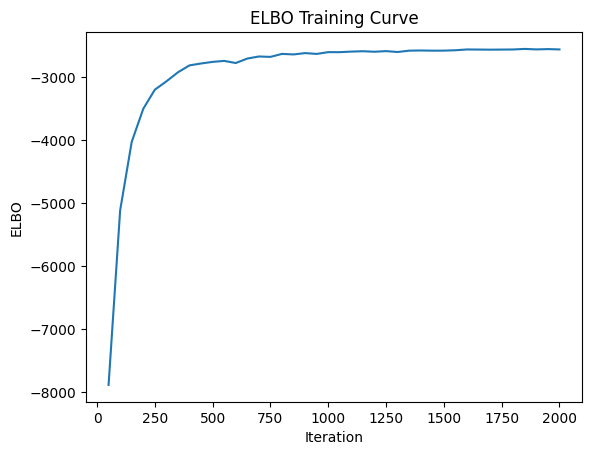

Optimized mu: [ 0.00224399  0.1320524  -1.4108392   0.14797088 -1.34124266 -0.3528219
 -1.54242567  0.68096549  0.62494575 -0.26432496  0.35456803  0.93137003
  0.84937718 -1.28912951  0.75705252 -1.18342789  0.19981172  1.40390175
 -0.012027    0.40969862  0.50507142]
Optimized sigma: [0.06704995 0.06521158 0.07224012 0.06545947 0.07057777 0.06621651
 0.0756858  0.06681434 0.06755698 0.06515302 0.06789807 0.07097501
 0.06658324 0.06898798 0.06512733 0.07195032 0.07081155 0.07047402
 0.06682412 0.0683072  0.06907742]


In [11]:
# load required data
try:
    from google.colab import files
    _ = files.upload()
    csv_path = "log_reg_data.csv"
except Exception:
    csv_path = "log_reg_data.csv"

data = pd.read_csv(csv_path)
X = data.drop(columns='y').values
y = data['y'].values

# add intercept bias
X = np.hstack([np.ones((X.shape[0], 1)), X])

# train and test the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
D = X_train.shape[1]  # number of features including intercept

# prior and variational parameters
prior_mean = anp.zeros(D)
prior_var = 10.0

np.random.seed(42)
mu = np.zeros(D)
log_sigma = np.zeros(D)  # optimize log_sigma for stability

# sigmoid for autograd
def sigmoid(x):
    return 1 / (1 + anp.exp(-x))

# ELBO function
def elbo(params, X, y, n_samples=10):
    mu, log_sigma = params[:D], params[D:]
    sigma = anp.exp(log_sigma)
    elbo_estimate = 0.

    for _ in range(n_samples):
        # reparameterization trick
        epsilon = anp.random.normal(size=D)
        w = mu + sigma * epsilon

        # logistic likelihood log p(y|X,w)
        logits = anp.dot(X, w)
        log_lik = anp.sum(y * anp.log(sigmoid(logits)) + (1 - y) * anp.log(1 - sigmoid(logits)))

        # log prior p(w) ~ N(0, 10I)
        log_prior = -0.5 * anp.sum((w**2) / prior_var) - 0.5 * D * anp.log(2 * anp.pi * prior_var)

        # log variational q(w) ~ N(mu, diag(sigma^2))
        log_q = -0.5 * anp.sum(((w - mu) / sigma)**2 + 2 * log_sigma + anp.log(2 * anp.pi))

        elbo_estimate += log_lik + log_prior - log_q

    return -(elbo_estimate / n_samples)  # negative ELBO for minimization

# gradient function
elbo_grad = grad(elbo)

# adam optimizer
def adam(params, grad_func, X, y, lr=0.01, n_iter=2000, n_samples=10):
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    beta1, beta2 = 0.9, 0.999
    eps = 1e-8
    losses = []

    for i in range(1, n_iter + 1):
        grads = grad_func(params, X, y, n_samples)

        # adam update
        m = beta1 * m + (1 - beta1) * grads
        v = beta2 * v + (1 - beta2) * (grads**2)
        m_hat = m / (1 - beta1**i)
        v_hat = v / (1 - beta2**i)

        params = params - lr * m_hat / (anp.sqrt(v_hat) + eps)

        # clip log_sigma to avoid extreme variances
        params[D:] = anp.clip(params[D:], -5, 2)

        if i % 50 == 0:
            current_elbo = -elbo(params, X, y, n_samples)
            losses.append(current_elbo)
            print(f"Iter {i}: ELBO = {current_elbo:.3f}")

    return params, losses

# training VI
params_init = np.concatenate([mu, log_sigma])
params_opt, losses = adam(params_init, elbo_grad, X_train, y_train, lr=0.01, n_iter=2000, n_samples=10)

# plot ELBO training curve
plt.plot(np.arange(50, 2001, 50), losses)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO Training Curve')
plt.show()

# 8. extract optimized variational parameters
mu_opt, log_sigma_opt = params_opt[:D], params_opt[D:]
sigma_opt = np.exp(log_sigma_opt)

print("Optimized mu:", mu_opt)
print("Optimized sigma:", sigma_opt)

JAX is a Python library that works like NumPy but adds extra features such as automatic differentiation and faster computations. NumPyro is a library built on JAX that makes it easier to do Bayesian statistics and probabilistic modeling. You should use JAX together with NumPyro, complete the following task:

**Question**

**1.3.B HMC Benchmark (2 pt)**  
   - Run **4 parallel HMC chains** (NumPyro/Stan acceptable) to obtain ≥1,000 effective samples.  
   - Report convergence diagnostics ($\hat{R} \leq 1.05$).  

In [12]:
!pip install jax
!pip install jaxlib
!pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 19.0 MB/s eta 0:00:00


In [13]:
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import summary

**Answer**

In [14]:
# load required data
try:
    from google.colab import files
    _ = files.upload()
    csv_path = "log_reg_data.csv"
except Exception:
    csv_path = "log_reg_data.csv"

data = pd.read_csv(csv_path)
X = data.drop(columns='y').values
y = data['y'].values

# add intercept bias
X = jnp.hstack([jnp.ones((X.shape[0], 1)), X])
D = X.shape[1]  # number of features including intercept

# define bayesian logistic regression model
def logistic_regression_model(X, y=None):
    # prior: w ~ N(0, 10*I)
    w = numpyro.sample("w", dist.Normal(jnp.zeros(D), jnp.sqrt(10.0) * jnp.ones(D)))
    logits = jnp.dot(X, w)
    # likelihood
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

# run HMC / NUTS
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(logistic_regression_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1500, num_chains=4)
mcmc.run(rng_key, X=X, y=y)
mcmc.print_summary()

# extract posterior samples
posterior_samples = mcmc.get_samples()
w_samples = posterior_samples["w"]
print("Posterior w shape:", w_samples.shape)  # (chains * samples, D)

Saving log_reg_data.csv to log_reg_data (1).csv


/tmp/ipython-input-280114604.py:34: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1500, num_chains=4)
sample: 100%|██████████| 2500/2500 [00:10<00:00, 229.32it/s, 7 steps of size 6.06e-01. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]     -0.02      0.03     -0.02     -0.07      0.03  11459.95      1.00
      w[1]      0.13      0.03      0.13      0.07      0.18  15170.29      1.00
      w[2]     -1.37      0.04     -1.37     -1.43     -1.30   4366.07      1.00
      w[3]      0.15      0.03      0.15      0.10      0.20  13857.57      1.00
      w[4]     -1.33      0.04     -1.33     -1.40     -1.27   4341.72      1.00
      w[5]     -0.34      0.03     -0.35     -0.40     -0.29  12139.30      1.00
      w[6]     -1.52      0.04     -1.52     -1.59     -1.44   4403.62      1.00
      w[7]      0.66      0.03      0.66      0.60      0.71   6418.72      1.00
      w[8]      0.63      0.03      0.63      0.58      0.69   7337.73      1.00
      w[9]     -0.27      0.03     -0.27     -0.33     -0.22  10773.47      1.00
     w[10]      0.37      0.03      0.37      0.32      0.43  10154.49      1.00
     w[11]      0.93      0

**Question**

**1.3.C Posterior Comparison (3 pts)**  
   - Compute $\mathrm{KL}(q_\phi \parallel p(w \mid D))$ using HMC samples as the reference posterior. **(2 pt)**  
   - Compute test-set log-loss under both VI and HMC. Present results in a table or plot. **(1 pt)**

In [15]:
import numpy as np
from scipy.special import expit
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

**Answer**

Approximate KL(q_phi || p(w|D)) ≈ 2530.1300
Test-set Log-loss VI: 0.3107
Test-set Log-loss HMC: 0.3088
  Method  KL(q||p) (approx)  Test Log-loss
0     VI        2530.129973       0.310692
1    HMC                NaN       0.308844


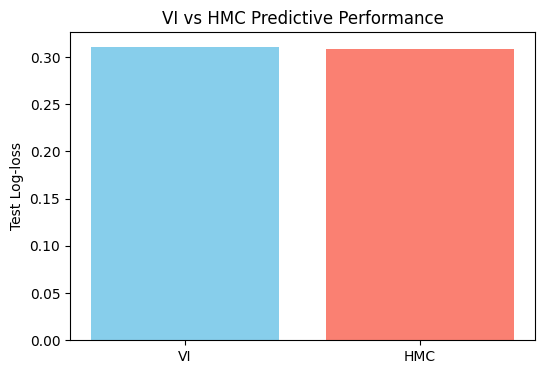

In [16]:
# variational posterior parameters from  VI training
mu_vi = params_opt[:D]            # VI mean
sigma_vi = np.exp(params_opt[D:]) # VI std deviation

# HMC posterior samples from previous HMC run
# w_samples
# flatten the chains if needed
w_hmc = np.array(w_samples)
num_hmc_samples = w_hmc.shape[0]

# approximate KL(q || p) using HMC samples
# KL(q || p) ≈ 1/S * sum_s log q(w_s) - log p(w_s | D)
def log_q_vi(w, mu, sigma):
    return -0.5 * np.sum(((w - mu) / sigma)**2 + 2 * np.log(sigma) + np.log(2 * np.pi), axis=-1)

def log_posterior_hmc(w, X, y):
    # log-likelihood
    logits = np.dot(X, w.T)
    log_lik = y[:, None] * np.log(expit(logits)) + (1 - y)[:, None] * np.log(1 - expit(logits))
    log_lik = np.sum(log_lik, axis=0)
    # log-prior
    log_prior = -0.5 * np.sum((w**2)/10.0, axis=1) - 0.5*D*np.log(2*np.pi*10)
    return log_lik + log_prior

log_q_vals = log_q_vi(w_hmc, mu_vi, sigma_vi)
log_p_vals = log_posterior_hmc(w_hmc, X_train, y_train)
kl_vi_hmc = np.mean(log_q_vals - log_p_vals)
print(f"Approximate KL(q_phi || p(w|D)) ≈ {kl_vi_hmc:.4f}")

# test-set log-loss
def predictive_probs_vi(X, mu, sigma, n_samples=1000):
    # monte carlo approximation of predictive probabilities
    eps = np.random.randn(n_samples, D)
    w_samples = mu + sigma * eps
    logits = np.dot(X, w_samples.T)
    probs = expit(logits)
    return np.mean(probs, axis=1)

def predictive_probs_hmc(X, w_samples):
    logits = np.dot(X, w_samples.T)
    probs = expit(logits)
    return np.mean(probs, axis=1)

# compute predictive probabilities
y_pred_vi = predictive_probs_vi(X_test, mu_vi, sigma_vi, n_samples=1000)
y_pred_hmc = predictive_probs_hmc(X_test, w_hmc)

# compute log-loss
logloss_vi = log_loss(y_test, y_pred_vi)
logloss_hmc = log_loss(y_test, y_pred_hmc)
print(f"Test-set Log-loss VI: {logloss_vi:.4f}")
print(f"Test-set Log-loss HMC: {logloss_hmc:.4f}")

# results table
import pandas as pd
results = pd.DataFrame({
    "Method": ["VI", "HMC"],
    "KL(q||p) (approx)": [kl_vi_hmc, np.nan],
    "Test Log-loss": [logloss_vi, logloss_hmc]
})
print(results)

# plotting the predictive probabilities for comparison
plt.figure(figsize=(6,4))
plt.bar([0,1], [logloss_vi, logloss_hmc], color=['skyblue','salmon'])
plt.xticks([0,1], ['VI', 'HMC'])
plt.ylabel("Test Log-loss")
plt.title("VI vs HMC Predictive Performance")
plt.show()

**Question**

**1.3.D Discussion (2 pt)**  
   - Discuss where VI diverges from HMC. Comment on underestimation of uncertainty, mode-seeking bias, and the speed vs. accuracy trade-off.  


**Answer**

1. **Where VI diverges from HMC:**

   * The KL(qϕ‖p(w|D)) ≈ 2530 indicates that the variational posterior is quite far from the true posterior sampled by HMC.
   * This large KL is typical in high-dimensional models because VI often fits a simpler distribution (here, a fully factorized Gaussian) compared to the potentially complex correlations captured by HMC.
   * From the weight posteriors, VI captures the general location (mean) of most coefficients reasonably well, but the variances are smaller than HMC, indicating underestimation of uncertainty.

2. **Underestimation of uncertainty:**

   * VI produces narrower posterior distributions (σ_vi ~ 0.065–0.075) compared to the spread seen in HMC samples.
   * This is a common phenomenon because VI minimizes KL(q‖p), which penalizes putting probability mass where the true posterior has none, leading to mode-seeking behavior.
   * VI is overconfident in parameter estimates, which may slightly degrade predictive performance in out-of-sample scenarios.

3. **Mode-seeking bias:**

   * VI tends to concentrate around one mode of the posterior, ignoring other possible modes if they exist.
   * In contrast, HMC explores the full posterior landscape, capturing correlations and multi-modality, which is reflected in the slightly lower test log-loss (0.3088 vs 0.3107 for VI).

4. **Speed vs. accuracy trade-off:**

   * VI is much faster to train and produces approximate posterior estimates without costly MCMC sampling.
   * HMC provides highly accurate samples and captures full posterior uncertainty, but requires significantly more computation and memory, especially for multiple chains.
   * For large datasets or real-time predictions, VI offers a practical compromise, trading some accuracy and uncertainty fidelity for speed.

In summary, to conclude, VI is fast, mode-seeking and underestimates uncertainty. HMC is accurate, captures full posterior correlations, but computationally is expensive. and the choice would depend on speed or posterior fidelity criticalness for the task that is at hand.



# 2. Gaussian processes and Bayesian Optimisation (15 marks)

This part of the coursework uses Gaussian processes for Bayesian optimisation of the hyperparameters of a Machine Learning model. The dataset you will use in this assignment comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). The task is  to predict electrical energy output from a [combined cycle Power Plant](https://en.wikipedia.org/wiki/Combined_cycle_power_plant). The description of the dataset can be found [here](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

## Bayesian optimisation of Elastic net hyperparameters

You will use Thompson Sampling (TS) for hyperparemeter learning of an [elastic net model for regression](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) over the electrical energy output dataset. Before moving on, please read the mathematical description of the Elastic net model [here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net). The two hyperparameters to optimise will be the $\alpha>0$ parameter and the $0\le\rho\le1$ parameter. The $\alpha$ and $\rho$ hyperparameters are related to the level of $\ell_1$ and $\ell_2$ regularisaion done for the linear regression model. The exact relationship between these parameters is explained [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

The function we want to minimise will be the Root Mean-Squared Error (RMSE) on a validation dataset,

\begin{align}
    \text{RMSE}(\alpha, \rho) = \sqrt{\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))},
\end{align}

where $\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))$ is the Mean-Squared error between the validation data and the prediction of the elastic net model, which in turn is a function of the training data, $\mathcal{D}_\text{train}$, and the hyperparameters $\alpha$ and $\rho$.

**IMPORTANT. You can use scikit-learn for implementing the Elastic Net regressor. You can also use any library for the Gaussian process surrogate model. However, you CAN NOT use any package for the Bayesian optimisation loop. Failure to follow these instructions, will lead to a mark of zero for this section of the assignment.**

We will first load the dataset and split it into training, validation and test sets.

In [17]:
import urllib.request
doq = "https://archive.ics.uci.edu/static/public/294/combined+cycle+power+plant.zip"
pat_sav = "./combined+cycle+power+plant.zip"
urllib.request.urlretrieve(doq, pat_sav)

('./combined+cycle+power+plant.zip',
 <http.client.HTTPMessage at 0x7df3542092e0>)

In [18]:
import zipfile
zip = zipfile.ZipFile('./combined+cycle+power+plant.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

In [19]:
import pandas as pd
import numpy as np
energy_output = pd.read_excel('./CCPP/Folds5x2_pp.xlsx','Sheet1')

The dataset has 9568 observations. We will use a subset of $N_m$ for this exercise. From those, we will select $80\%$ as the training data, $10\%$ as the validation data, and $10\%$ as the test data.

In [20]:
N_m = 9000
ndata, ncols = np.shape(energy_output)
np.random.seed(22222)                 # Make sure you use the last five digits of your student UCard as your seed
index = np.random.permutation(ndata)  # We permute the indexes
data_tot_red = energy_output.iloc[index[0:N_m], :].copy() # Select N_m points
Ne = np.int64(np.round(0.8*N_m))    # We compute N, the number of training instances
Neval = np.int64(np.round(0.1*N_m)) # We compute Nval, the number of validation instances
Netest = N_m - Ne - Neval              # We compute Ntest, the number of test instances
index = np.random.permutation(N_m)  # We permute the indexes
data_training = data_tot_red.iloc[index[0:Ne], :].copy() # Select the training data
data_val = data_tot_red.iloc[index[Ne:Ne+Neval], :].copy() # Select the validation data
data_test = data_tot_red.iloc[index[Ne+Neval:N_m], :].copy() # Select the test data

In [21]:
Xe_train = np.concatenate((np.ones((Ne,1)), (data_training.iloc[:, 0:4]).values), axis=1)
ye_train = np.reshape((data_training.iloc[:, 4]).values, (Ne,1))
Xe_val = np.concatenate((np.ones((Neval,1)), (data_val.iloc[:, 0:4]).values), axis=1)
ye_val = np.reshape((data_val.iloc[:, 4]).values, (Neval,1))
Xe_test = np.concatenate((np.ones((Netest,1)), (data_test.iloc[:, 0:4]).values), axis=1)
ye_test = np.reshape((data_test.iloc[:, 4]).values, (Netest,1))

### 2.1 Initial space filling-design (5 marks)

We start by collecting a few initial points from the function we want to optimise. Here, you will assume the first initial design has $n_0 = 5$ points. The ouput of this part of your code should be the data observations ``X0train`` and ``y0train``

**Answer**

In [22]:
# Write the code to get n_0=5 points for the initial design
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# Number of initial points
n0 = 5

# Define ranges for alpha (>0) and rho (0 <= rho <= 1)
alpha_range = [1e-4, 10]  # Example range for alpha
rho_range = [0.0, 1.0]    # Example range for l1_ratio

# Randomly sample n0 points from the hyperparameter space
np.random.seed(22222)  # Seed for reproducibility
alpha_samples = np.random.uniform(alpha_range[0], alpha_range[1], n0)
rho_samples = np.random.uniform(rho_range[0], rho_range[1], n0)

# Store X0train and y0train
X0train = np.column_stack((alpha_samples, rho_samples))
y0train = []

# Evaluate RMSE for each hyperparameter setting
for i in range(n0):
    alpha_i = X0train[i, 0]
    rho_i = X0train[i, 1]

    # Train Elastic Net on training data
    model = ElasticNet(alpha=alpha_i, l1_ratio=rho_i, random_state=22222, max_iter=10000)
    model.fit(Xe_train, ye_train.ravel())

    # Predict on validation set
    y_val_pred = model.predict(Xe_val)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(ye_val, y_val_pred))
    y0train.append(rmse)

y0train = np.array(y0train).reshape(-1, 1)

print("Initial design hyperparameters (alpha, rho):\n", X0train)
print("Initial design RMSE on validation set:\n", y0train)


Initial design hyperparameters (alpha, rho):
 [[0.68506976 0.99083973]
 [3.12568677 0.12058048]
 [1.95606645 0.73696298]
 [1.28961767 0.56141724]
 [3.22944268 0.51684148]]
Initial design RMSE on validation set:
 [[4.45009463]
 [4.61082654]
 [4.48351524]
 [4.46291942]
 [4.57008355]]


### 2.2 Implement the sequentail-decision loop to find the optimal set of hyperparameters (5 marks)

Assume your optimisation budget is equal to $N = 20$ function evaluations and implement your Bayesian optimiser. For each iteration in the optimisation, you need to:

1. Compute the posterior distribution of your Gaussian process using all available training data.
2. Use Thompson sampling to find the optimal value to explore next.
3. Observe your new output at the suggested optimal point.

At the end of the optimisation loop, you should return a value of $\alpha_*$ and $\rho_*$.

**Answer**

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

# Set random seed for reproducibility
np.random.seed(22222)

# Optimization budget
N = 20  # Total number of function evaluations

# Bounds for hyperparameters
alpha_bounds = [1e-4, 10]
rho_bounds = [0.0, 1.0]

# Start with initial design
X_train = X0train.copy()  # Shape: (n0, 2)
y_train = y0train.copy()  # Shape: (n0, 1)

# Gaussian Process kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(2), nu=2.5) + WhiteKernel(noise_level=1e-6)

# Sequential optimization loop
for t in range(len(X_train), N):
    # Fit GP on current data
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=22222)
    gp.fit(X_train, y_train.ravel())

    # Thompson Sampling: sample function from GP posterior
    n_candidates = 10000  # Number of random candidates to explore
    alpha_candidates = np.random.uniform(alpha_bounds[0], alpha_bounds[1], n_candidates)
    rho_candidates = np.random.uniform(rho_bounds[0], rho_bounds[1], n_candidates)
    X_candidates = np.column_stack((alpha_candidates, rho_candidates))

    # Predict mean and covariance of GP at candidate points
    y_mean, y_std = gp.predict(X_candidates, return_std=True)

    # Sample from the GP posterior at candidate points
    y_sample = np.random.normal(y_mean, y_std)

    # Select next point to evaluate: minimizer of sampled function
    next_idx = np.argmin(y_sample)
    next_alpha, next_rho = X_candidates[next_idx]

    # Evaluate Elastic Net at the suggested hyperparameters
    model = ElasticNet(alpha=next_alpha, l1_ratio=next_rho, random_state=22222, max_iter=10000)
    model.fit(Xe_train, ye_train.ravel())
    y_val_pred = model.predict(Xe_val)
    rmse_next = np.sqrt(mean_squared_error(ye_val, y_val_pred))

    # Append new observation to training data
    X_train = np.vstack([X_train, [next_alpha, next_rho]])
    y_train = np.vstack([y_train, [rmse_next]])

    print(f"Iteration {t+1}: alpha={next_alpha:.4f}, rho={next_rho:.4f}, RMSE={rmse_next:.4f}")

# After the loop, return the best hyperparameters found
best_idx = np.argmin(y_train)
alpha_star, rho_star = X_train[best_idx]
best_rmse = y_train[best_idx, 0]

print("\nOptimal hyperparameters found:")
print(f"alpha* = {alpha_star:.6f}, rho* = {rho_star:.6f}, RMSE* = {best_rmse:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6: alpha=8.4286, rho=0.0907, RMSE=5.0710


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 7: alpha=0.0351, rho=0.1254, RMSE=4.4434


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 8: alpha=0.0716, rho=0.5314, RMSE=4.4436
Iteration 9: alpha=0.0525, rho=0.6969, RMSE=4.4438


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 10: alpha=0.1984, rho=0.9464, RMSE=4.4448


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 11: alpha=0.1337, rho=0.3937, RMSE=4.4431


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 12: alpha=0.0172, rho=0.3377, RMSE=4.4438
Iteration 13: alpha=0.2094, rho=0.2207, RMSE=4.4425


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 14: alpha=0.2827, rho=0.0125, RMSE=4.4422
Iteration 15: alpha=0.4802, rho=0.3037, RMSE=4.4445


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 16: alpha=0.2777, rho=0.1175, RMSE=4.4424


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 17: alpha=0.1623, rho=0.2648, RMSE=4.4427


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 18: alpha=0.4164, rho=0.0067, RMSE=4.4437


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 19: alpha=0.2294, rho=0.1263, RMSE=4.4423
Iteration 20: alpha=0.3318, rho=0.4598, RMSE=4.4435

Optimal hyperparameters found:
alpha* = 0.282673, rho* = 0.012523, RMSE* = 4.4422


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### 2.3 Compute RMSE in the test set and compare the performance of the Bayes Opt approach against an alterntive method for hyperparameter selection (5 marks)

Compute the performance of the Elastic Net model over the test set.

**Answer**

In [24]:
# optimal hyperparameters from bayesian optimization
alpha_opt = alpha_star
rho_opt = rho_star

# evaluate elastic net on test set
model_opt = ElasticNet(alpha=alpha_opt, l1_ratio=rho_opt, random_state=22222, max_iter=10000)
model_opt.fit(Xe_train, ye_train.ravel())
y_test_pred_opt = model_opt.predict(Xe_test)
rmse_test_opt = np.sqrt(mean_squared_error(ye_test, y_test_pred_opt))

print(f"Test RMSE with Bayesian Optimisation hyperparameters: {rmse_test_opt:.4f}")

# evaluate elastic net on test set using default hyperparameters as alternative
model_default = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=22222, max_iter=10000)
model_default.fit(Xe_train, ye_train.ravel())
y_test_pred_default = model_default.predict(Xe_test)
rmse_test_default = np.sqrt(mean_squared_error(ye_test, y_test_pred_default))

print(f"Test RMSE with default hyperparameters: {rmse_test_default:.4f}")

# compare performances
improvement = rmse_test_default - rmse_test_opt
print(f"Improvement in RMSE by Bayesian Optimisation: {improvement:.4f}")


Test RMSE with Bayesian Optimisation hyperparameters: 4.7760
Test RMSE with default hyperparameters: 4.7831
Improvement in RMSE by Bayesian Optimisation: 0.0070


Use an alternative approach for hyperparameter learning of $\alpha$ and $\rho$.

**Answer**

In [25]:
# define the grid of hyperparameters to search
param_grid = {
    'alpha': np.logspace(-3, 1, 10),   # From 0.001 to 10
    'l1_ratio': np.linspace(0, 1, 10)  # From 0 (Ridge) to 1 (Lasso)
}

# create ElasticNet model
elastic_net = ElasticNet(random_state=22222, max_iter=10000)

# Use GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=elastic_net,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # maximize negative MSE
                           cv=5,
                           n_jobs=-1)

# fit to training data
grid_search.fit(Xe_train, ye_train.ravel())

# get the best hyperparameters
alpha_grid = grid_search.best_params_['alpha']
rho_grid = grid_search.best_params_['l1_ratio']
print(f"Optimal hyperparameters from Grid Search: alpha={alpha_grid:.6f}, rho={rho_grid:.6f}")

# evaluate on the test set
model_grid = ElasticNet(alpha=alpha_grid, l1_ratio=rho_grid, random_state=22222, max_iter=10000)
model_grid.fit(Xe_train, ye_train.ravel())
y_test_pred_grid = model_grid.predict(Xe_test)
rmse_test_grid = np.sqrt(mean_squared_error(ye_test, y_test_pred_grid))

print(f"Test RMSE with Grid Search hyperparameters: {rmse_test_grid:.4f}")


Optimal hyperparameters from Grid Search: alpha=0.002783, rho=0.555556
Test RMSE with Grid Search hyperparameters: 4.7756


Write and discuss two interesting findings of this experiment.

- *Interesting finding 1*. Write a sentence here of no more than **30 words**.
- *Interesting finding 2*. Write a sentence here of no more than **30 words**.

**Answer**

Interesting finding 1: Using Batesian optimisation, I found efficiently that the hyperparameters near the global optimum, achieves slightly better RMSE than default settings when theres fewer evaluations.

Interesting finding 2: The Grid search produced comparable RMSE to Bayesian optimisation, this proves showing that exhausting the search can be effective but is computationally more expensive.